## Imports

In [14]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import sys
import os

In [16]:
# add library tree module to PYTHONPATH
sys.path.append(f"{os.getcwd()}/../..")

In [17]:
import numpy as np
from random import randint
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import graphviz
from graphviz import Source

from matplotlib import pyplot as plt

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

from woodpecker.decision_tree_structure import DecisionTreeStructure


## Util functions

In [18]:
def print_scores(model, train, valid, features, target):
    """Print metrics specific to this dataset
    """
    
    prediction_train = model.predict(train[features])
    prediction_valid = model.predict(valid[features])
    print(f"train accuracy {accuracy_score(train[target], prediction_train)}")
    print(f"valid accuracy {accuracy_score(valid[target], prediction_valid)}")
    
def save_decision_tree_structure(model_param, filename_param, features_param):
    graph = Source(sklearn.tree.export_graphviz(model_param, feature_names=features_param, class_names=["0", "1"],
                                                filled=True, node_ids=True))
    graph.format = 'png'
    graph.render(filename=filename_param,view=True)
    

## Prepare dataset

In [19]:
dataset = pd.read_csv("../../resources/dataset/train_titanic.csv")

# Feature transformation
# Age
dataset["Age_na"] = dataset["Age"].isna().astype(int)
dataset.fillna({"Age":dataset.median()["Age"]}, inplace=True)

#Sex
dataset["Sex_label"] = dataset["Sex"].astype("category").cat.codes

#Cabin
dataset["Cabin_label"] = dataset["Cabin"].astype("category").cat.codes

# Embarked
dataset["Embarked_label"] = dataset["Embarked"].astype("category").cat.codes


# Feature selection
features = ["Pclass", "Age", "Fare", "Sex_label", "Cabin_label", "Embarked_label"]
target = "Survived"

# Split dataset in train and validation
random_state = 1987
train, valid = train_test_split(dataset, test_size = 0.2, stratify = dataset.Survived, random_state=random_state)



## Woodpecker library

The library was started with two main ideas in my mind :
- To help me understand the decision tree performance and its structure
- To easily explain/justify the model prediction for some specific input.

Github link [woodpecker](https://github.com/tlapusan/woodpecker)


### Describe dataset

 [Titanic dataset](https://www.kaggle.com/c/titanic/data])

<b>Features</b> :
- <b>Pclass</b> : socio-economic status
    - 1st = Upper
    - 2nd = Middle
    - 3rd = Lower
- <b>Age</b> : passanger age
- <b>Fare</b> : ticket price
- <b>Sex_label</b> : the passanger gender
    - 0 = female
    - 1 = male
- <b>Cabin_label</b> - the cabin number
- <b>Embarked_label</b> - the port number 


<b>Target</b>
- <b>Survived</b> :
    - 1 = Survived
    - 0 = Didn't survive
   


In [20]:
dataset[features + [target]].head(10)

,Pclass,Age,Fare,Sex_label,Cabin_label,Embarked_label,Survived
0,3,22.0,7.2500,1,-1,2,0
1,1,38.0,71.2833,0,81,0,1
2,3,26.0,7.9250,0,-1,2,1
3,1,35.0,53.1000,0,55,2,1
4,3,35.0,8.0500,1,-1,2,0
5,3,28.0,8.4583,1,-1,1,0
6,1,54.0,51.8625,1,129,2,0
7,3,2.0,21.0750,1,-1,2,0
8,3,27.0,11.1333,0,-1,2,1
9,2,14.0,30.0708,0,-1,0,1


### Train/validation split

In [41]:
train, valid = train_test_split(dataset, test_size = 0.2, stratify = dataset.Survived, random_state=random_state)

### Decision tree 

In [42]:
max_depth = 10
decision_tree = DecisionTreeClassifier(criterion="entropy", max_depth=max_depth, random_state=random_state)
_ = decision_tree.fit(train[features], train[target])

In [43]:
print_scores(decision_tree, train, valid, features, target)

train accuracy 0.9171348314606742
valid accuracy 0.8212290502793296


In [44]:
save_decision_tree_structure(decision_tree, f"dtree_rander_{max_depth}", features)

### Library setup

Let start using the [Woodpecker](https://github.com/tlapusan/woodpecker) library

In [45]:
woodpecker_dts = DecisionTreeStructure(tree=decision_tree, train_dataset=train, features=features, target=target)

###  Understand decision tree performance and structure

A decision tree has two types of nodes  
- Split nodes, used to split the features space
- Leaf nodes, used to make the final predictions

The decision tree overall performance is given by each leaf performance. <br>
So it's very important to have a way to investigate the information contained in each leaf : <b>impurity and leaf samples </b>

#### Leaves impurity distribution

Impurity value shows how pure or impure is a node

In [46]:
print(f"Number of leaves = {woodpecker_dts.get_leaf_node_count()}")

Number of leaves = 73


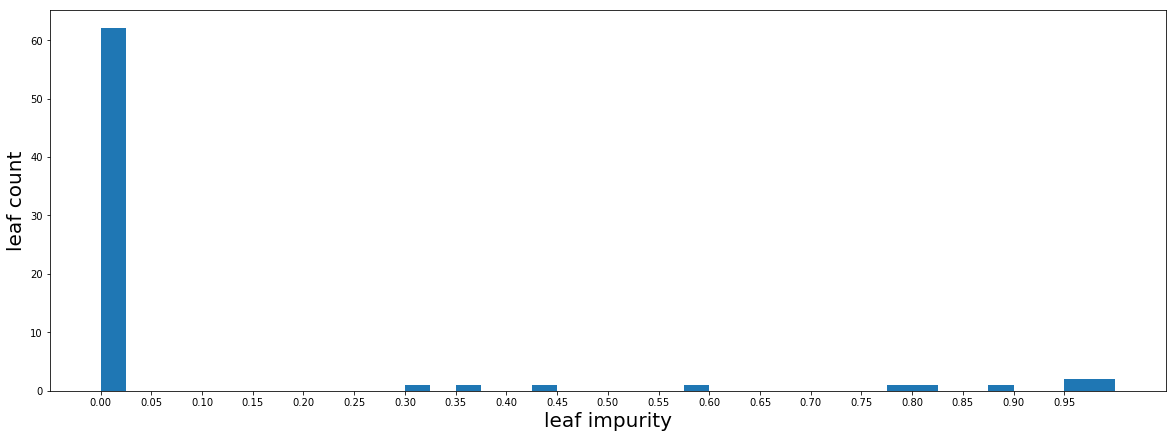

In [47]:
woodpecker_dts.show_leaf_impurity_distribution(bins=40, figsize=(20,7))

#### Leaves sample distribution

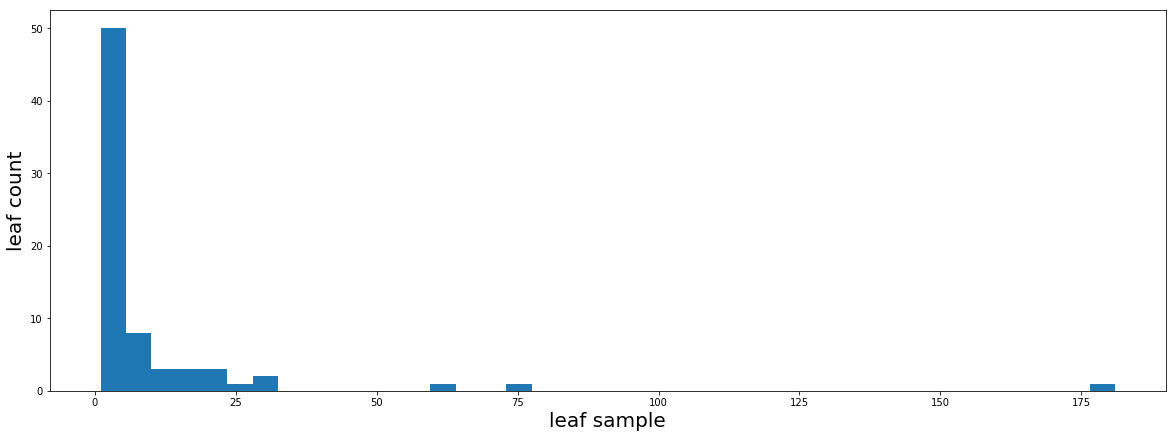

In [48]:
woodpecker_dts.show_leaf_samples_distribution(bins=40, figsize=(20,7))

#### Impurity and samples for each leaf

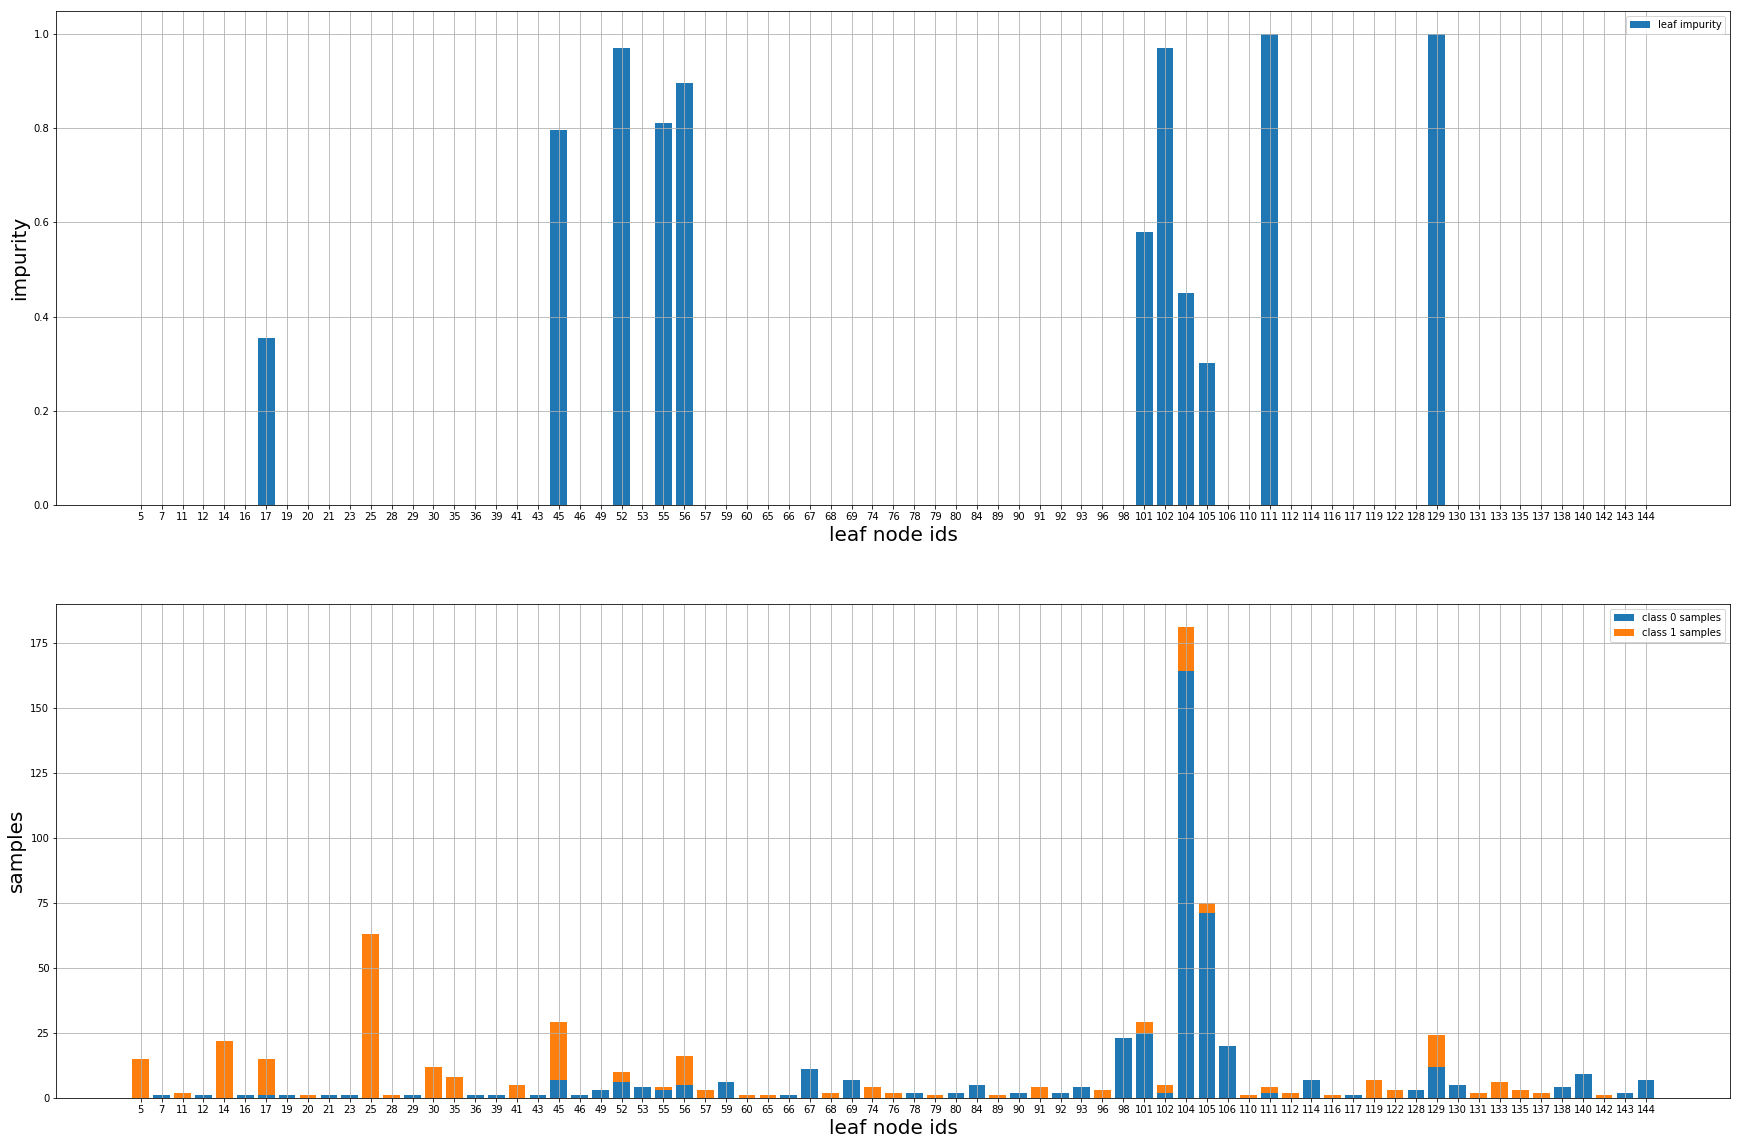

In [29]:
plt.figure(figsize=(30,20))
plt.subplot(2,1,1)
woodpecker_dts.show_leaf_impurity()

plt.subplot(2,1,2)
woodpecker_dts.show_leaf_samples_by_class()

#### Investigate node samples

Investigate training samples reaching a specific/interesting leaf help us to get domain knowledge about the data and also to follow a model drive approach during project development.


In [49]:
woodpecker_dts.get_node_samples(node_id=25)

INFO - decision paths [[1 0 0 ... 0 0 0]
 [1 1 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 1 0 ... 0 0 0]] 


,Pclass,Age,Fare,Sex_label,Cabin_label,Embarked_label,Survived
8,2,3.0,41.5792,0,-1,0,1
15,1,14.0,120.0000,0,47,2,1
54,1,16.0,57.9792,0,17,0,1
56,1,53.0,51.4792,0,48,2,1
63,1,62.0,80.0000,0,21,-1,1
68,1,35.0,90.0000,0,87,2,1
71,1,36.0,71.0000,0,20,2,1
86,1,30.0,31.0000,0,-1,0,1
96,1,44.0,57.9792,0,17,0,1
99,2,24.0,65.0000,0,-1,2,1


In [50]:
woodpecker_dts.get_node_samples(25).describe()

,Pclass,Age,Fare,Sex_label,Cabin_label,Embarked_label,Survived
count,63.000000,63.000000,63.000000,63.0,63.000000,63.000000,63.0
mean,1.111111,30.873016,78.484192,0.0,62.222222,1.015873,1.0
std,0.316794,13.184169,30.415129,0.0,47.161167,1.023783,0.0
min,1.000000,3.000000,29.000000,0.0,-1.000000,-1.000000,1.0
25%,1.000000,22.500000,55.000000,0.0,19.500000,0.000000,1.0
50%,1.000000,28.000000,78.266700,0.0,65.000000,2.000000,1.0
75%,1.000000,38.500000,92.289600,0.0,100.500000,2.000000,1.0
max,2.000000,63.000000,146.520800,0.0,144.000000,2.000000,1.0


In [19]:
woodpecker_dts.get_node_samples(98)

,Pclass,Age,Fare,Sex_label,Cabin_label,Embarked_label,Survived
7,3,18.0,7.8542,1,-1,2,0
16,2,16.0,10.5000,1,-1,2,0
31,2,16.0,26.0000,1,-1,2,0
84,2,18.0,11.5000,1,-1,2,0
135,2,18.0,13.0000,1,-1,2,0
162,3,16.0,20.2500,1,-1,2,0
169,3,16.0,7.7750,1,-1,2,0
208,3,18.0,7.7958,1,-1,2,0
250,3,11.0,18.7875,1,-1,0,0
254,3,17.0,7.2292,1,-1,0,0


In [20]:
woodpecker_dts.get_node_samples(98).describe()

,Pclass,Age,Fare,Sex_label,Cabin_label,Embarked_label,Survived
count,23.000000,23.000000,23.000000,23.0,23.0,23.000000,23.0
mean,2.782609,16.869565,10.912865,1.0,-1.0,1.826087,0.0
std,0.421741,1.546384,5.264038,0.0,0.0,0.576208,0.0
min,2.000000,11.000000,6.495800,1.0,-1.0,0.000000,0.0
25%,3.000000,16.000000,7.775000,1.0,-1.0,2.000000,0.0
50%,3.000000,17.000000,8.662500,1.0,-1.0,2.000000,0.0
75%,3.000000,18.000000,11.500000,1.0,-1.0,2.000000,0.0
max,3.000000,18.000000,26.000000,1.0,-1.0,2.000000,0.0


### Explain/justify the model prediction

In [51]:
sample = valid[features].iloc[randint(0, len(valid))]
sample

Pclass             3.0000
Age               28.0000
Fare               7.2292
Sex_label          1.0000
Cabin_label       -1.0000
Embarked_label     0.0000
Name: 832, dtype: float64

INFO - Make a prediction for sample Pclass             3.0000
Age               28.0000
Fare               7.2292
Sex_label          1.0000
Cabin_label       -1.0000
Embarked_label     0.0000
Name: 832, dtype: float64
INFO - decision path [  0  70  71  81  82  94  95  97  99 100 101]


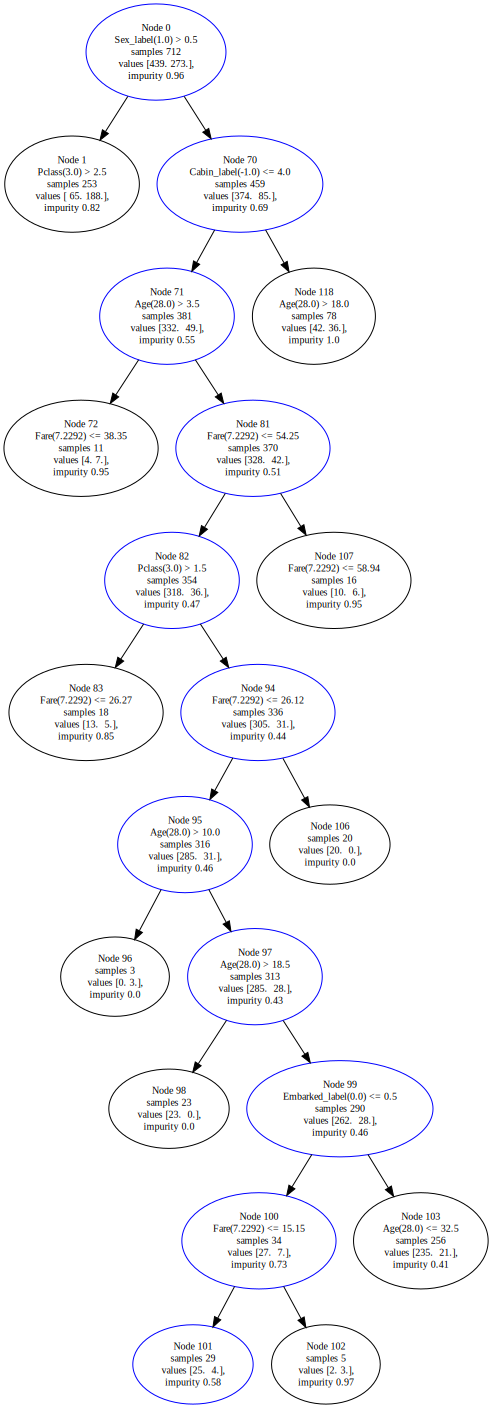

In [52]:
woodpecker_dts.show_decision_tree_prediction_path(sample)